45
[[ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 ...
 [42 42 42 ... 44 44 44]
 [42 42 42 ... 44 44 44]
 [42 42 42 ... 44 44 44]]


<Figure size 640x480 with 0 Axes>

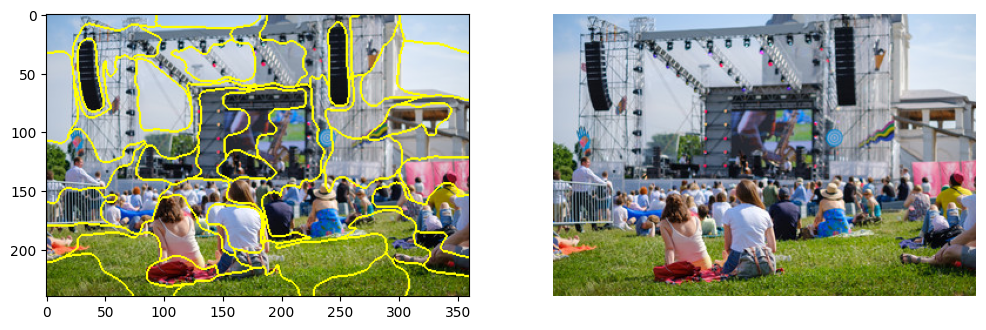

In [20]:
import sys
# allow import from Textons folder
sys.path.insert(1, 'Textons-master/')

# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, exposure
from skimage.transform import resize
import skimage.feature as feature

import matplotlib.pyplot as plt
import argparse
import numpy as np
import cv2
from textons_utils import Textons

image = img_as_float(io.imread("training_images/concertpic1.jpeg"))
# loop over the number of segments
numSegments =  50
# apply SLIC and extract (approximately) the supplied number
# of segments
segments = slic(image, n_segments = numSegments, sigma = 5)

# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(mark_boundaries(image, segments))
ax2.imshow(image)

print(np.max(segments))
print(segments)
plt.axis("off")
# show the plots
plt.show()

RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

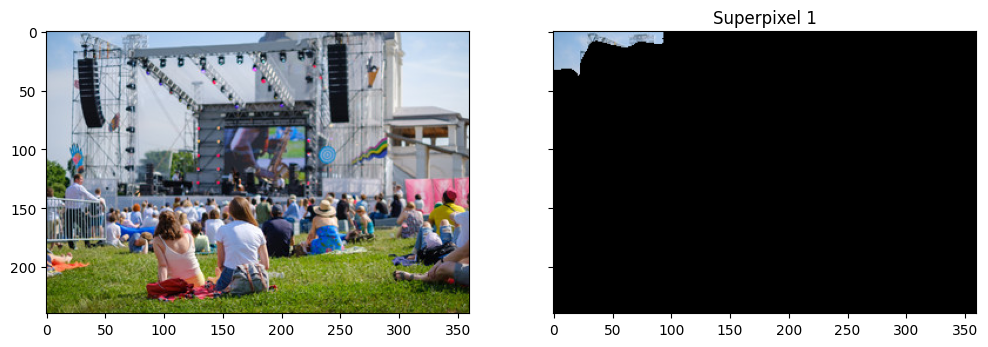

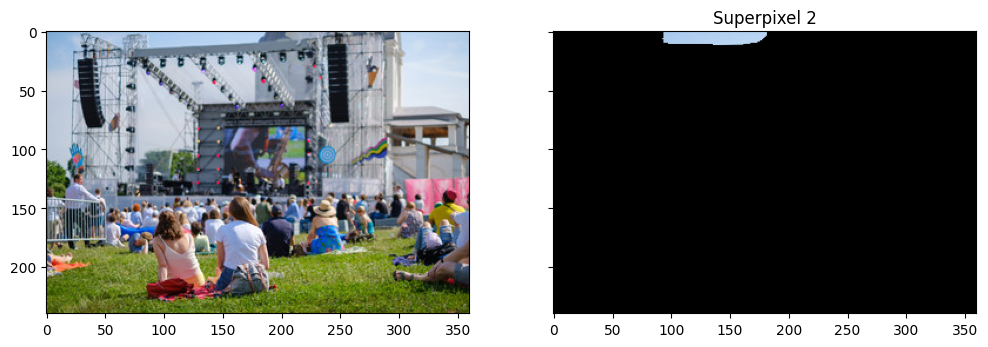

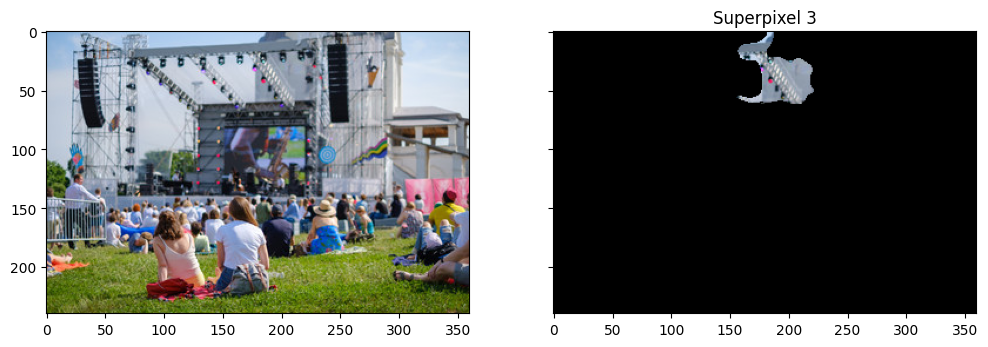

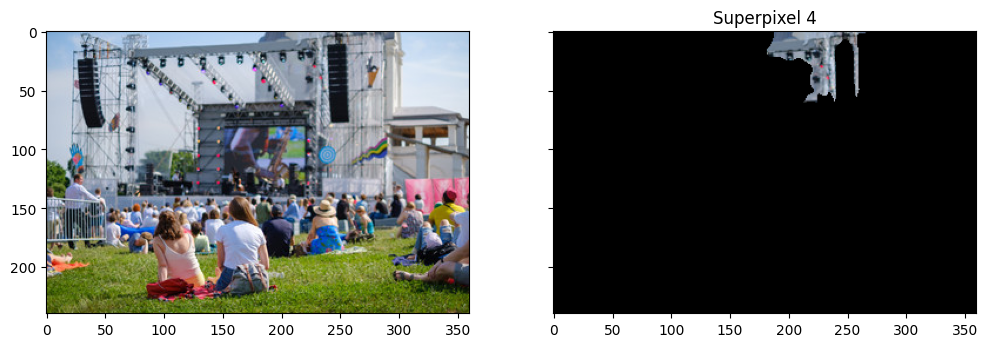

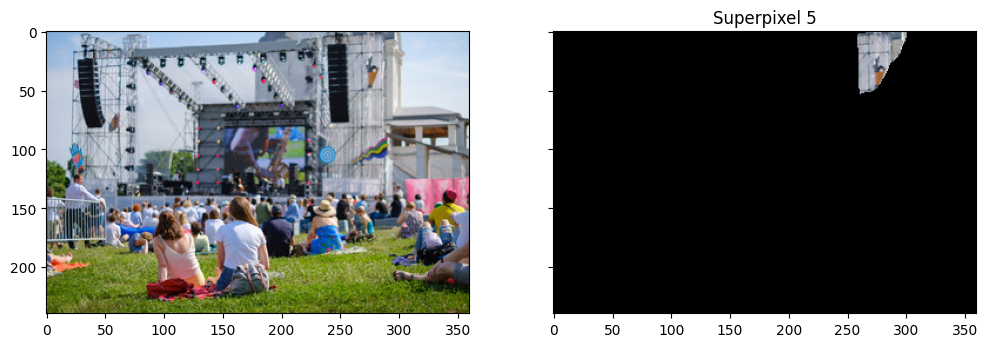

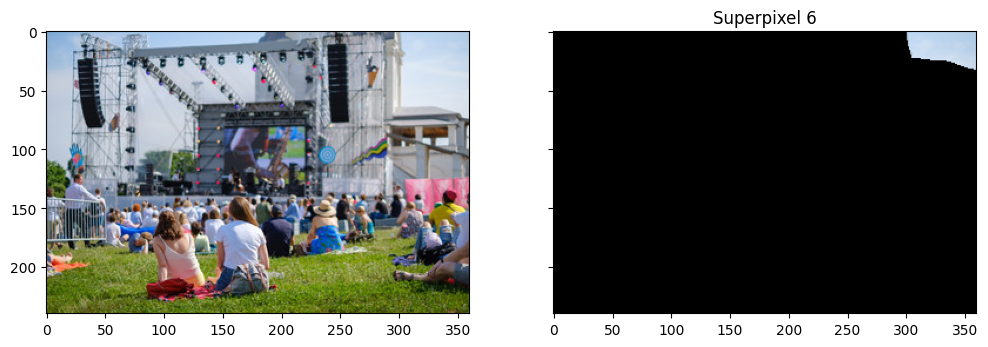

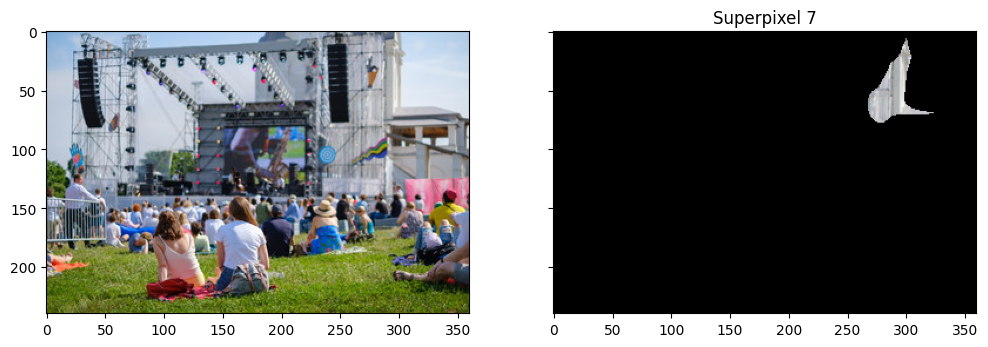

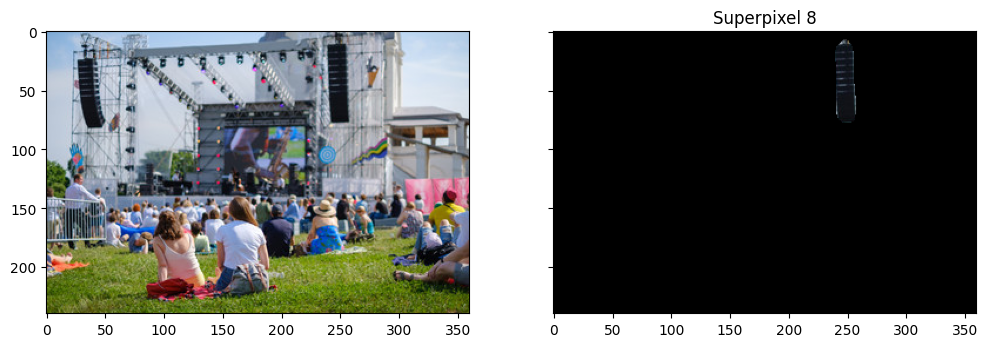

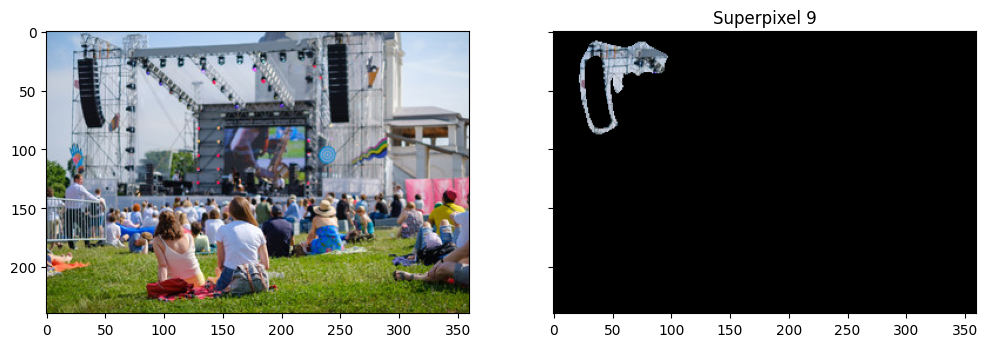

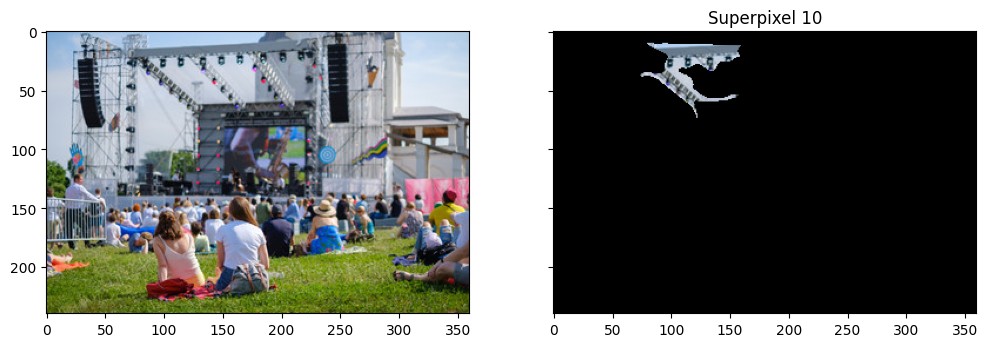

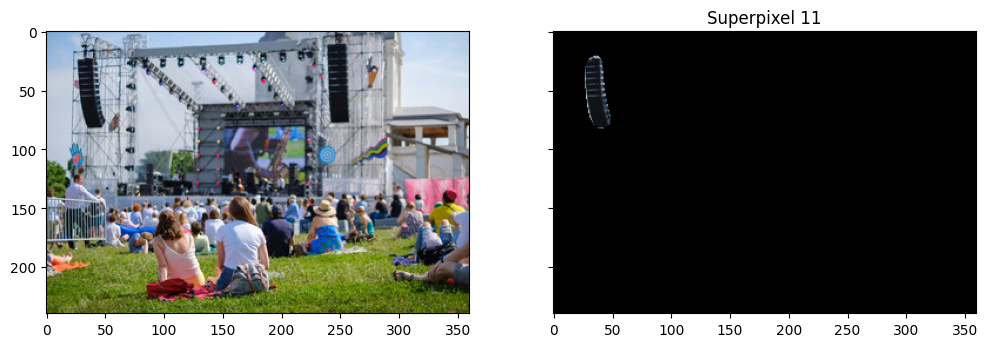

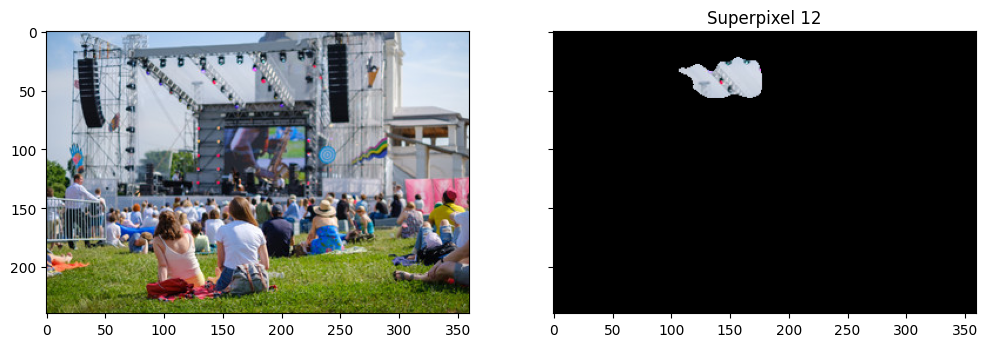

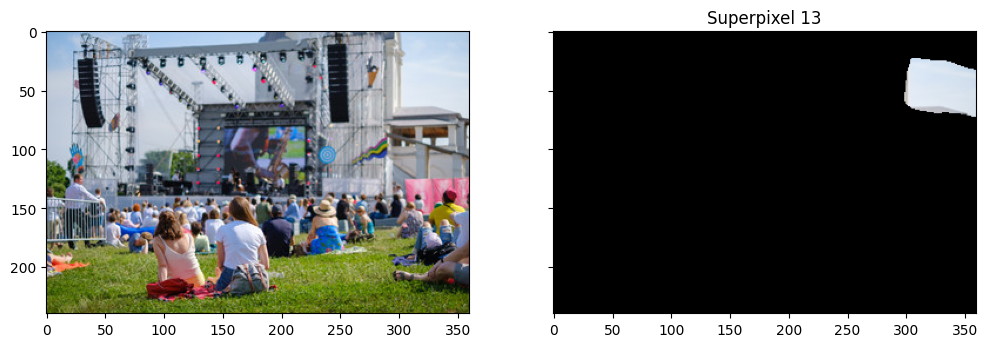

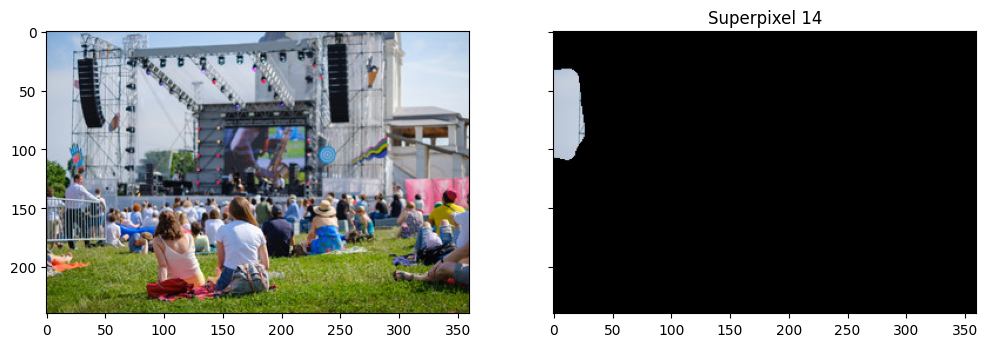

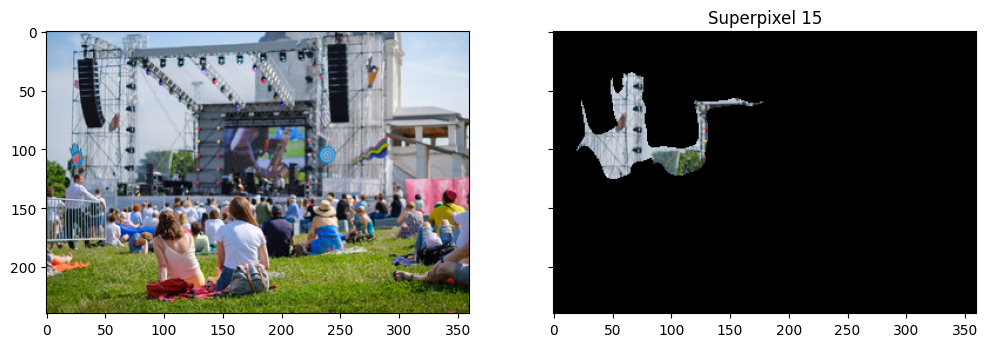

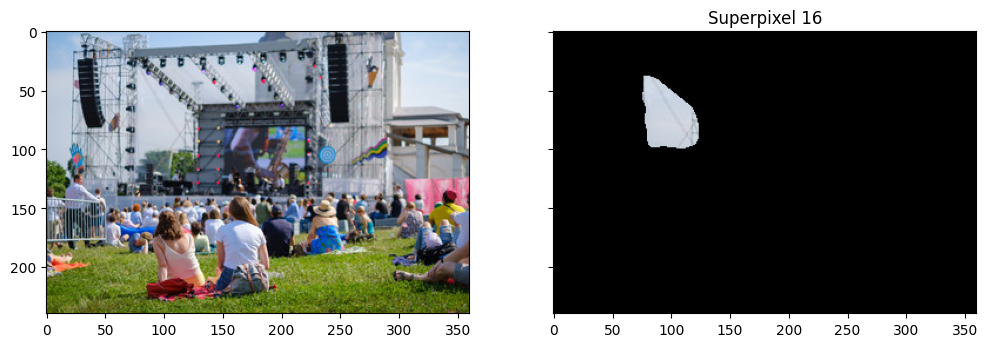

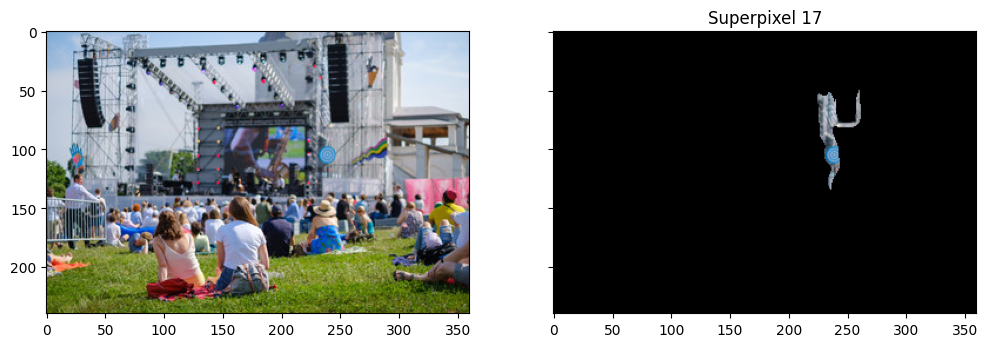

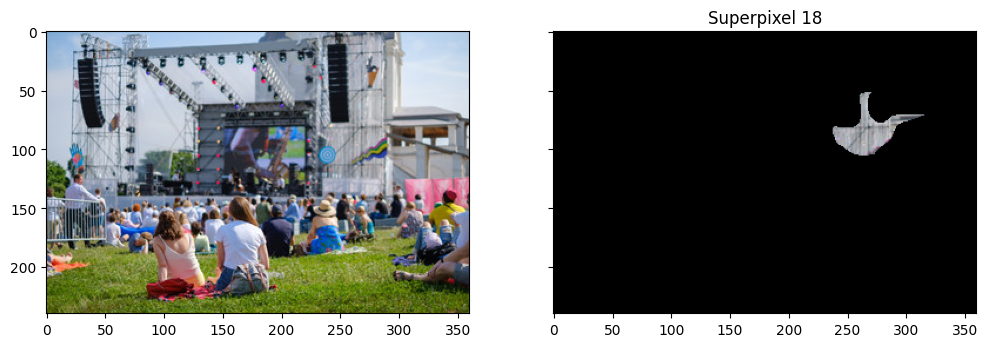

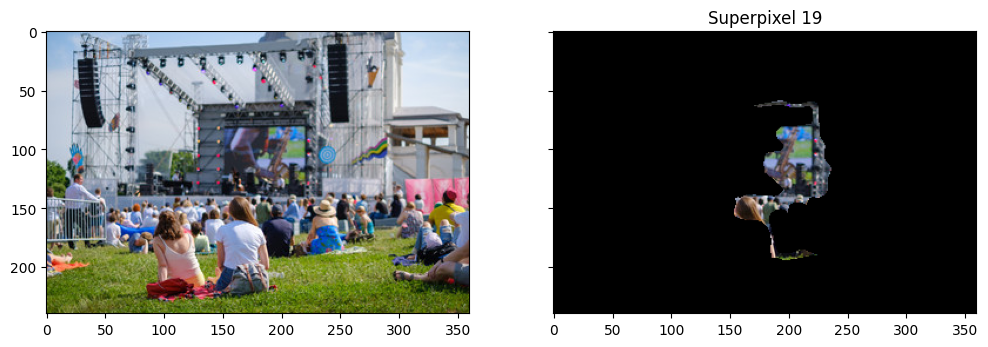

<Figure size 640x480 with 0 Axes>

In [86]:
def showNthSuperPixel(segments, image, n):
  mask = (segments == n).astype(int)
  H, W, _ = image.shape
  superpixel = np.zeros(image.shape)
  superpixel[:, :, 0] = mask * image[:, :, 0]
  superpixel[:, :, 1] = mask * image[:, :, 1]
  superpixel[:, :, 2] = mask * image[:, :, 2]

  fig = plt.figure("Superpixels -- %d segments" % (numSegments))
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
  plt.title("Superpixel %d" % n)
  ax1.imshow(image)
  ax2.imshow(superpixel)

  #print(generateFeatureVector(n, image, segments))

def showAllSuperPixels(segments, image):
  maxSegment = np.max(segments)

  for n in range(1, maxSegment + 1):
    showNthSuperPixel(segments, image, n)
    
showAllSuperPixels(segments, image)

In [ ]:
def processSuperPixels(image,segments)
# Create list of np.max(segments)-1 slots
# for each superpixel, in segments, generate featurevector and store the feature vector in the list at the superpixel # slot

SyntaxError: expected ':' (<ipython-input-10-a24ff5397cbd>, line 1)

In [82]:
# Source for image cropping: https://stackoverflow.com/questions/40824245/how-to-crop-image-based-on-binary-mask
def get_segment_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

# Generate feature vector given superpixel number
def generateFeatureVector(superpixel,image,segments):
  mask = (segments == superpixel).astype(int)
  superpixelIm = np.zeros(image.shape)
  superpixelIm[:, :, 0] = mask * image[:, :, 0]
  superpixelIm[:, :, 1] = mask * image[:, :, 1]
  superpixelIm[:, :, 2] = mask * image[:, :, 2]
  superpixel_subimg = get_segment_crop(superpixelIm, mask=mask)
  mask_subimg = get_segment_crop(mask, mask=mask)
  Bmean, Gmean, Rmean, Hmean, Smean, Vmean = getRGBMeanandHSVValues(superpixel_subimg, mask_subimg)
  
  H, W, _= superpixel_subimg.shape
  
  L1X, L1Y = getL1Value(superpixel_subimg,H,W,mask_subimg)
  featureVector = [Bmean, Gmean, Rmean, Hmean, Smean, Vmean, L1X, L1Y]

  #contrast, dissimilarity, homogeneity, energy, correlation, ASM = getTextureValues(superpixel_subimg)
  for result in getTextureValues(superpixel_subimg):
    for feature_value in result[0]:
        featureVector.append(feature_value)

  return np.array(featureVector)



In [44]:
def getRGBMeanandHSVValues(superpixel , mask):
  #print(superpixel[mask].shape)

  B = superpixel[:,:,0]
  G = superpixel[:,:,1]
  R = superpixel[:,:,2]
 # B, G , R = cv2.split(superpixel[mask])

  Bmean = np.mean(B[mask==1])
  Gmean = np.mean(G[mask==1])
  Rmean = np.mean(R[mask==1])

  H,S,V = cv2.split(cv2.cvtColor(cv2.merge((Bmean, Gmean, Rmean)).astype('float32'), cv2.COLOR_BGR2HSV))
  Hmean = H[0][0]
  Smean = S[0][0]
  Vmean = V[0][0]

  return Bmean , Gmean , Rmean , Hmean, Smean, Vmean


In [45]:
def getL1Value(superpixel,H,W, mask):
  '''
  Location in the image also provides strong cues for distinguishing
  between ground (tends to be low in the image), vertical structures,
  and sky (tends to be high in the image). We normalize the pixel
  locations by the width and height of the image and compute the
  mean (L1) of the x- and y-location
  of a region in the image.
      '''
  count, sumX, sumY = 0, 0, 0
  for x in range (0,W):
   for y in range (0,H):
     if mask[y,x] == 1 :
      count += 1
      xPos = x / W
      yPos = y / H
      sumX += xPos
      sumY += yPos
  return sumX/count, sumY/count


In [63]:
def getTextureValues(superpixel_im):
    gray_img = (255 * cv2.cvtColor(superpixel_im.astype('float32'), cv2.COLOR_BGR2GRAY)).astype('uint8')

    graycom = feature.graycomatrix(gray_img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    # Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    
    return contrast, dissimilarity, homogeneity, energy, correlation, ASM

1. Generate Superpixels (https://pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/)
2. For each superpixel, generate feature vector

* C1. RGB values: mean (getRGBMeanandHSVValues)
* C2. HSV values: conversion from mean RGB values: see RGB
* T1. DOOG (derivative of gaussian) Filters: mean abs response
* T2. DOOG Filters: mean of variables in T1
* T3. DOOG Filters: id of max of variables in T1
* T4. DOOG Filters: (max - median) of variables in T1
* T5. Textons: mean abs response
* T6. Textons: max of variables in T5
* T7. Textons: (max - median) of variables in T5
* L1. Location: normalized x and y, mean